# 1. Dataset
## 1.1 Dataset Features


| Attribute              | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| A - fighter1           | Name of the first fighter.                                                  |
| B - fighter2           | Name of the second fighter.                                                 |
| C - event              | Name of the UFC event where the fight took place.                           |
| D - fight_outcome      | Indicates which fighter won the fight.                                      |
| E - origin_fight_url   | URL linking to the original source of the fight details.                    |
| F - fighter1_Name      | Full name of fighter 1.                                                     |
| G - fighter1_Nickname  | Nickname of fighter 1.                                                      |
| H - fighter1_Record    | Fight record (wins-losses-draws) of fighter 1.                              |
| I - fighter1_Height    | Height of fighter 1.                                                        |
| J - fighter1_Weight    | Weight of fighter 1.                                                        |
| K - fighter1_Reach     | Reach of fighter 1.                                                         |
| L - fighter1_Stance    | Fighting stance of fighter 1 (e.g., Orthodox, Southpaw).                    |
| M - fighter1_DOB       | Date of birth of fighter 1.                                                 |
| N - fighter1_SLpM      | Significant strikes landed per minute by fighter 1.                         |
| O - fighter1_StrAcc    | Striking accuracy of fighter 1.                                             |
| P - fighter1_SApM      | Significant strikes absorbed per minute by fighter 1.                       |
| Q - fighter1_StrDef    | Striking defense percentage of fighter 1.                                   |
| R - fighter1_TDAvg     | Average takedowns per 15 minutes for fighter 1.                             |
| S - fighter1_TDAcc     | Takedown accuracy of fighter 1.                                             |
| T - fighter1_TDDef     | Takedown defense percentage of fighter 1.                                   |
| U - fighter1_SubAvg    | Average number of submissions attempted per 15 minutes by fighter 1.        |
| V - fighter2_Name      | Full name of fighter 2.                                                     |
| W - fighter2_Nickname  | Nickname of fighter 2.                                                      |
| X - fighter2_Record    | Fight record (wins-losses-draws) of fighter 2.                              |
| Y - fighter2_Height    | Height of fighter 2.                                                        |
| Z - fighter2_Weight    | Weight of fighter 2.                                                        |
| AA - fighter2_Reach    | Reach of fighter 2.                                                         |
| AB - fighter2_Stance   | Fighting stance of fighter 2 (e.g., Orthodox, Southpaw).                    |
| AC - fighter2_DOB      | Date of birth of fighter 2.                                                 |
| AD - fighter2_SLpM     | Significant strikes landed per minute by fighter 2.                         |
| AE - fighter2_StrAcc   | Striking accuracy of fighter 2.                                             |
| AF - fighter2_SApM     | Significant strikes absorbed per minute by fighter 2.                       |
| AG - fighter2_StrDef   | Striking defense percentage of fighter 2.                                   |
| AH - fighter2_TDAvg    | Average takedowns per 15 minutes for fighter 2.                             |
| AI - fighter2_TDAcc    | Takedown accuracy of fighter 2.                                             |
| AJ - fighter2_TDDef    | Takedown defense percentage of fighter 2.                                   |
| AK - fighter2_SubAvg   | Average number of submissions attempted per 15 minutes by fighter 2.        |


## 1.2. Dataset Features Cleaned

| Attribute              | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| A - fighter1           | Name of the first fighter.                                                  |
| B - fighter2           | Name of the second fighter.                                                 |
| D - fight_outcome      | Indicates which fighter won the fight.                                      |
| G - fighter1_Nickname  | Nickname of fighter 1.                                                      |
| H - fighter1_Record    | Fight record (wins-losses-draws) of fighter 1.                              |
| I - fighter1_Height    | Height of fighter 1.                                                        |
| J - fighter1_Weight    | Weight of fighter 1.                                                        |
| K - fighter1_Reach     | Reach of fighter 1.                                                         |
| L - fighter1_Stance    | Fighting stance of fighter 1 (e.g., Orthodox, Southpaw).                    |
| M - fighter1_DOB       | Date of birth of fighter 1.                                                 |
| N - fighter1_SLpM      | Significant strikes landed per minute by fighter 1.                         |
| O - fighter1_StrAcc    | Striking accuracy of fighter 1.                                             |
| P - fighter1_SApM      | Significant strikes absorbed per minute by fighter 1.                       |
| Q - fighter1_StrDef    | Striking defense percentage of fighter 1.                                   |
| R - fighter1_TDAvg     | Average takedowns per 15 minutes for fighter 1.                             |
| S - fighter1_TDAcc     | Takedown accuracy of fighter 1.                                             |
| T - fighter1_TDDef     | Takedown defense percentage of fighter 1.                                   |
| U - fighter1_SubAvg    | Average number of submissions attempted per 15 minutes by fighter 1.        |
| W - fighter2_Nickname  | Nickname of fighter 2.                                                      |
| X - fighter2_Record    | Fight record (wins-losses-draws) of fighter 2.                              |
| Y - fighter2_Height    | Height of fighter 2.                                                        |
| Z - fighter2_Weight    | Weight of fighter 2.                                                        |
| AA - fighter2_Reach    | Reach of fighter 2.                                                         |
| AB - fighter2_Stance   | Fighting stance of fighter 2 (e.g., Orthodox, Southpaw).                    |
| AC - fighter2_DOB      | Date of birth of fighter 2.                                                 |
| AD - fighter2_SLpM     | Significant strikes landed per minute by fighter 2.                         |
| AE - fighter2_StrAcc   | Striking accuracy of fighter 2.                                             |
| AF - fighter2_SApM     | Significant strikes absorbed per minute by fighter 2.                       |
| AG - fighter2_StrDef   | Striking defense percentage of fighter 2.                                   |
| AH - fighter2_TDAvg    | Average takedowns per 15 minutes for fighter 2.                             |
| AI - fighter2_TDAcc    | Takedown accuracy of fighter 2.                                             |
| AJ - fighter2_TDDef    | Takedown defense percentage of fighter 2.                                   |
| AK - fighter2_SubAvg   | Average number of submissions attempted per 15 minutes by fighter 2.        |

# 2. Import libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3. DataSet Attributes Analysis
# 3.1. Cleaned Dataset
 - Drops the 'fighter1_Name', 'fighter2_Name', 'origin_fight_url' and 'event' columns

In [7]:
df = pd.read_csv("ufc_all_fights.csv")

columns_to_drop = ['fighter1_Name', 'fighter2_Name', 'origin_fight_url', 'event']
df_cleaned = df.drop(columns=columns_to_drop)

## 3.2. Dataset Individual Attributes Analysis

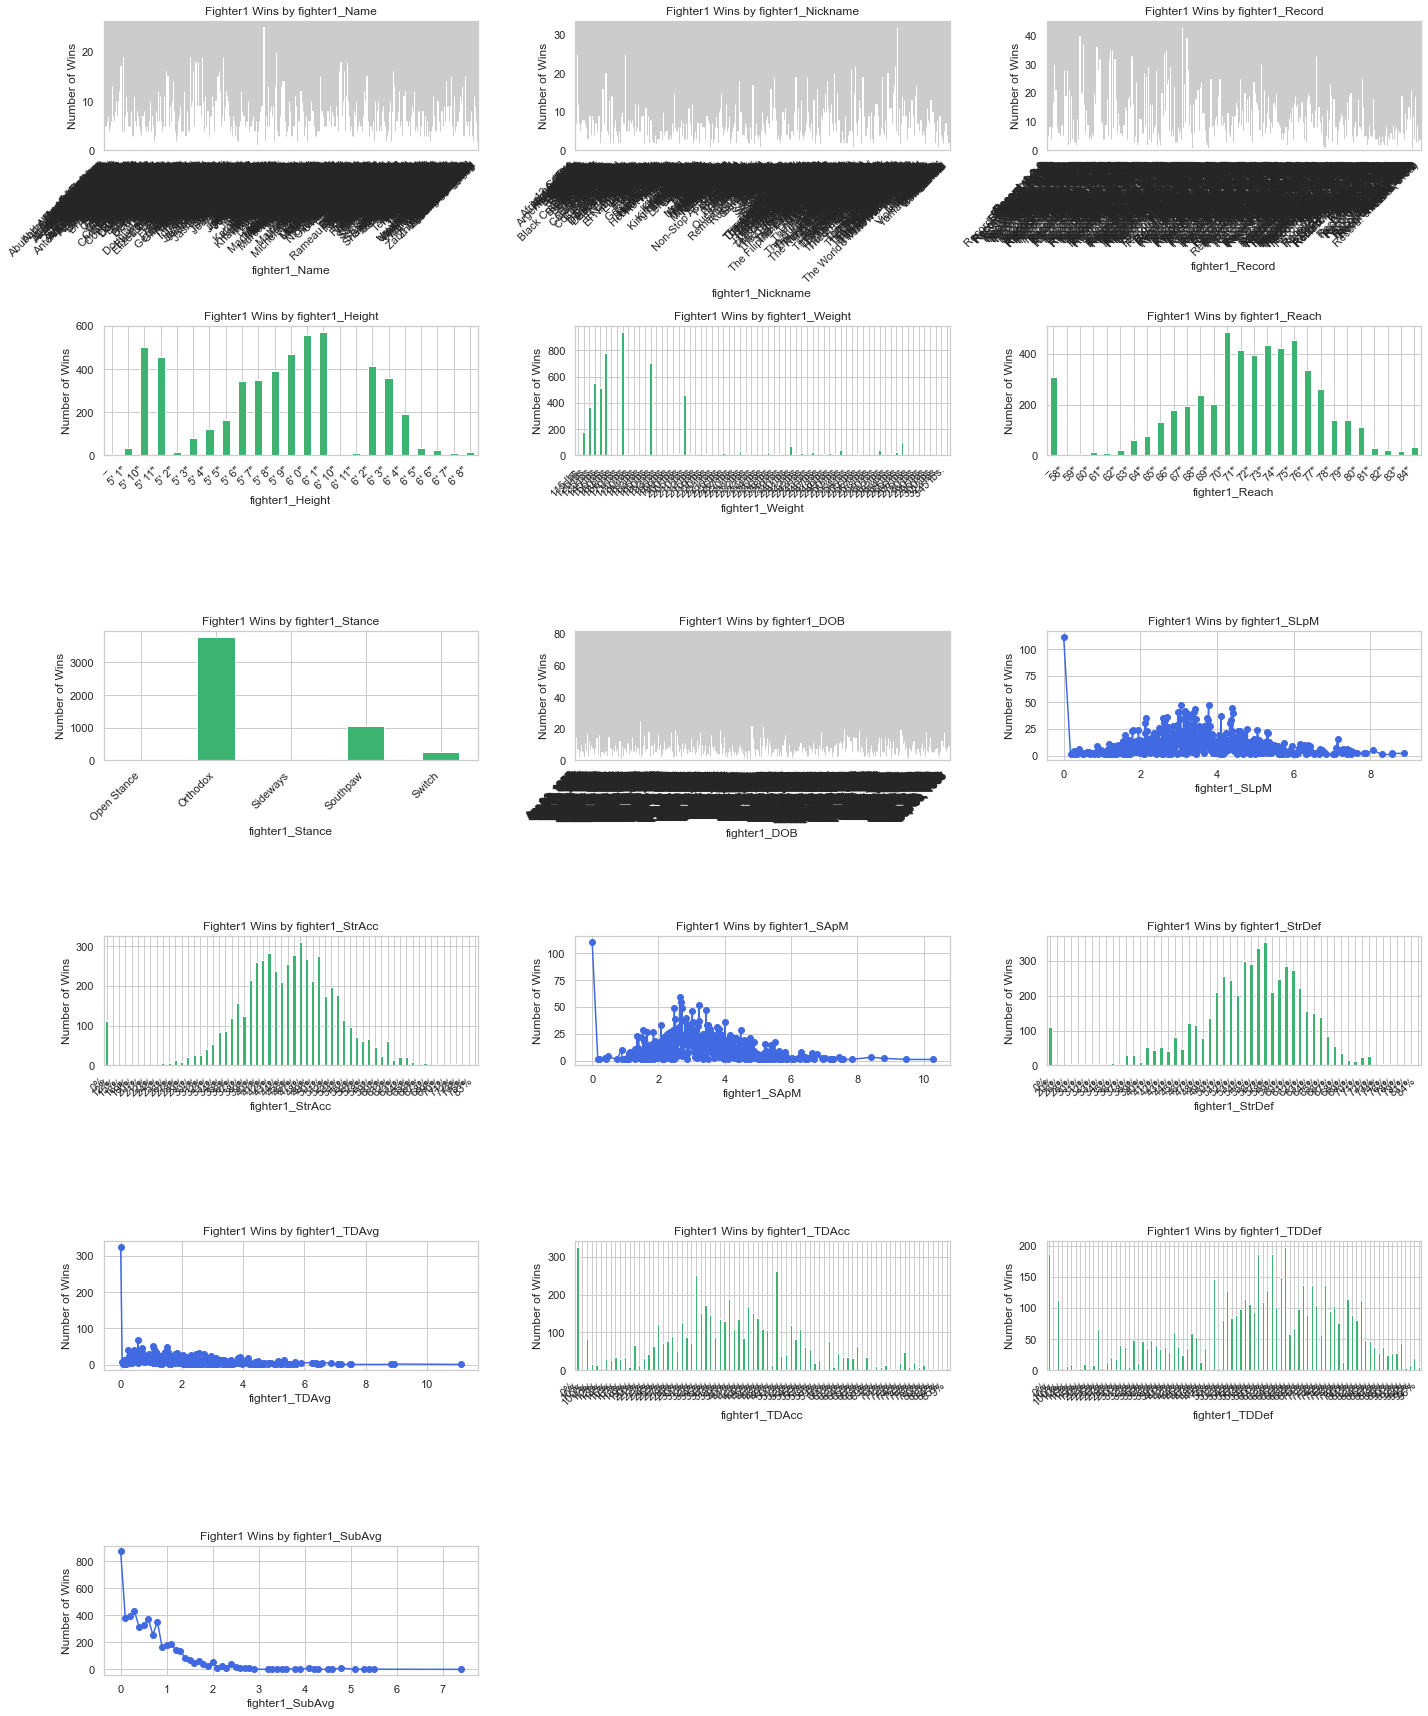

In [10]:
df['fighter1_win'] = (df['fight_outcome'] == 'fighter1').astype(int)

# List of fighter1 attributes (excluding the outcome label)
fighter1_attributes = [col for col in df.columns if col.startswith('fighter1_') and col != 'fighter1_win']

# Plot configuration
ncols = 3
nrows = (len(fighter1_attributes) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
axes = axes.flatten()

# Generate one plot per attribute
for idx, col in enumerate(fighter1_attributes):
    ax = axes[idx]
    wins = df[df['fighter1_win'] == 1]

    if df[col].dtype == 'object' or df[col].nunique() < 10:
        win_counts = wins[col].value_counts().sort_index()
        win_counts.plot(kind='bar', ax=ax, color='mediumseagreen')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        win_counts = wins[col].value_counts().sort_index()
        win_counts.plot(kind='line', marker='o', ax=ax, color='royalblue')

    ax.set_title(f'Fighter1 Wins by {col}')
    ax.set_ylabel('Number of Wins')
    ax.set_xlabel(col)

# Remove any empty subplots
for j in range(len(fighter1_attributes), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

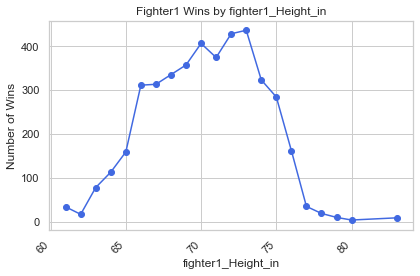

In [14]:
wins = df[df['fighter1_win'] == 1]

# Escolher a característica a analisar
col = 'fighter1_Height_in'  # Substitua por outra se quiser

# Verificar se a característica é categórica ou numérica
if df[col].dtype == 'object' or df[col].nunique() < 10:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='bar', color='mediumseagreen')
else:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='line', marker='o', color='royalblue')

# Adicionar títulos e rótulos
plt.title(f'Fighter1 Wins by {col}')
plt.ylabel('Number of Wins')
plt.xlabel(col)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

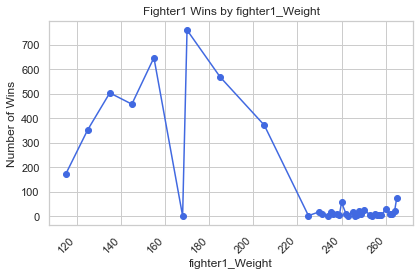

In [15]:
wins = df[df['fighter1_win'] == 1]

# Escolher a característica a analisar
col = 'fighter1_Weight'  # Substitua por outra se quiser

# Verificar se a característica é categórica ou numérica
if df[col].dtype == 'object' or df[col].nunique() < 10:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='bar', color='mediumseagreen')
else:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='line', marker='o', color='royalblue')

# Adicionar títulos e rótulos
plt.title(f'Fighter1 Wins by {col}')
plt.ylabel('Number of Wins')
plt.xlabel(col)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

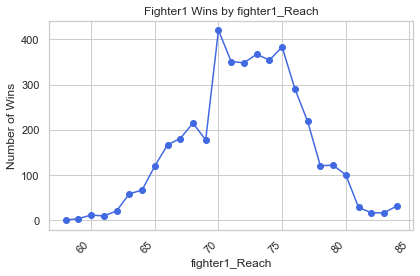

In [16]:
wins = df[df['fighter1_win'] == 1]

# Escolher a característica a analisar
col = 'fighter1_Reach'  # Substitua por outra se quiser

# Verificar se a característica é categórica ou numérica
if df[col].dtype == 'object' or df[col].nunique() < 10:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='bar', color='mediumseagreen')
else:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='line', marker='o', color='royalblue')

# Adicionar títulos e rótulos
plt.title(f'Fighter1 Wins by {col}')
plt.ylabel('Number of Wins')
plt.xlabel(col)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

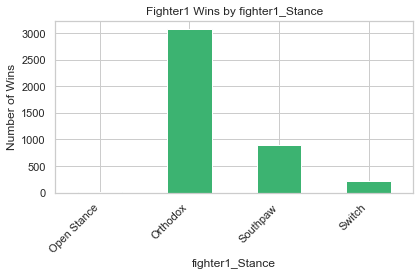

In [17]:
wins = df[df['fighter1_win'] == 1]

# Escolher a característica a analisar
col = 'fighter1_Stance'  # Substitua por outra se quiser

# Verificar se a característica é categórica ou numérica
if df[col].dtype == 'object' or df[col].nunique() < 10:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='bar', color='mediumseagreen')
else:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='line', marker='o', color='royalblue')

# Adicionar títulos e rótulos
plt.title(f'Fighter1 Wins by {col}')
plt.ylabel('Number of Wins')
plt.xlabel(col)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

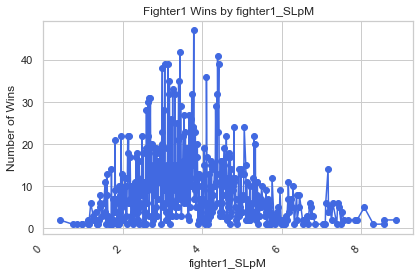

In [18]:
wins = df[df['fighter1_win'] == 1]

# Escolher a característica a analisar
col = 'fighter1_SLpM'  # Substitua por outra se quiser

# Verificar se a característica é categórica ou numérica
if df[col].dtype == 'object' or df[col].nunique() < 10:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='bar', color='mediumseagreen')
else:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='line', marker='o', color='royalblue')

# Adicionar títulos e rótulos
plt.title(f'Fighter1 Wins by {col}')
plt.ylabel('Number of Wins')
plt.xlabel(col)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

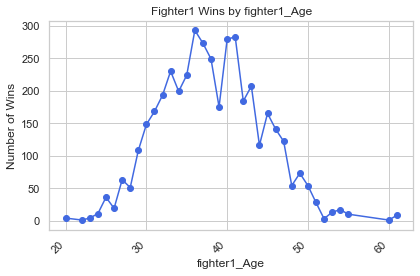

In [19]:
wins = df[df['fighter1_win'] == 1]

# Escolher a característica a analisar
col = 'fighter1_Age'  # Substitua por outra se quiser

# Verificar se a característica é categórica ou numérica
if df[col].dtype == 'object' or df[col].nunique() < 10:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='bar', color='mediumseagreen')
else:
    win_counts = wins[col].value_counts().sort_index()
    win_counts.plot(kind='line', marker='o', color='royalblue')

# Adicionar títulos e rótulos
plt.title(f'Fighter1 Wins by {col}')
plt.ylabel('Number of Wins')
plt.xlabel(col)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()